# 01_Lecture_Intro

**Content:**
1) Use DuckDuckGo to search for images of "bird photos" and "forest photos"
3) Fine-tune a pretrained neural network to recognise these two groups
4) Try running this model on a picture of a bird and see if it works


**Comments:**  
About labels, you can find documentation here:  
docs.fast.ai >> tutorials >> intermediate >> DataBlock Tutorial OR Data >> Blocks

About biuit-in models (which are Pytorch), documentation is here:  
timm.fast.ai >> Models >> Model architectures >> find last string "results (here)" - any model here might be used as an alternative to resnet

# Step 1: Create a dataset
## 1) Download images of birds and non-birds (forest)
Let's start by searching for a bird photo and seeing what kind of result we get.  


We'll start by getting URLs from a search:

In [10]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

get the link:

In [12]:
urls = search_images('bird photos', max_images=1)
urls[0]

/var/folders/j3/wtk_67ds4z5gnr0bcf6jc3ph0000gn/T/ipykernel_97196/616225101.py:1: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

download a URL and take a look at it:

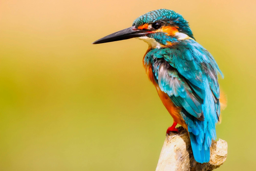

In [13]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

/var/folders/j3/wtk_67ds4z5gnr0bcf6jc3ph0000gn/T/ipykernel_97196/616225101.py:1: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


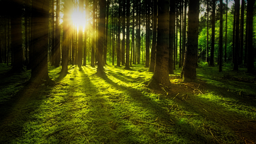

In [14]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

## 2) Create a dataset
let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [15]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/var/folders/j3/wtk_67ds4z5gnr0bcf6jc3ph0000gn/T/ipykernel_97196/616225101.py:1: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97196) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97196) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning:

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97196) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97196) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97196) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=97196) is multi-threaded, u

3

# Step 2: Train the model

To train a model, we'll need DataLoaders, which is an object that contains a training set and a validation set. In fastai we can create that easily using a DataBlock, and view sample images from it:

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

# dls.show_batch(max_n=6)

_______________
Comment:
- blocks = ImageBlock - inputs to our model are images, CategoryBlock - outputs are categories (in this case, "bird" or "forest").
- get_items = runs get_image_files fn which returns a list of all image files in a path
- RandomSplitter = splits the data into training and validation sets randomly
- parent_label = the labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).
- item_tfms = before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).
_______________

Create CNN with parameters:

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Train our model:

In [21]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.787416,0.626659,0.136986,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.254950,0.280990,0.095890,00:05
1,0.161778,0.361597,0.109589,00:04
2,0.107572,0.358014,0.123288,00:04


# Step 3: Run the model

In [22]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


# Exercise
Click "Copy & Edit" and try creating your own image classifier using your own image searches!